In [2]:
import nbsetup
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ergodicpy as ep
import scipy as sp

SAVE_FIGURES = False
x_points = 50

# Aim

- To determine the relationship between bins and ergodic complexity
- So that we can develop a reliable method of determining the metric for models with a continuous distribution

### We've tried
- Relative entropy, however, this dilutes the sensitivity of the complexity metric
- Differential entropy, however, this often leads to negative and infinite entropies, which again make little sense of the metric

### What we're trying here
- Finding a specific number of states to use which leads to consistent results

### Broadly what we found
- Is when there are too few bins, the complexity increases dramatically because the effects of the differences compound wildly within the course bin structure
- However, equally if there are too many bins, complexity also increases, as there are too few observations per bin, leading to noise to appear as complexity signal
- Therefore, there is always a minimum complexity level for every distribution
- This minimum level appears to be very stable across increasingly levels of complexity
- This minimum level appears at different positions, depending on the complexity of the system & the distribution of the system itself
- However, it is often within the first fifth of bins, implying you need at least 5 observations per bin for it to be reliable

In [3]:
def bin_scan(obs=2000, x=20, bin_count=50, minimum=2, maximum=None, power=3, log=False):
    data = []
    if maximum is None: maximum = obs/2
    for mix in ep.binspace(0,1,20):
        #nbsetup.cp(mix)
        if power is not None:
            observations = np.array([
                np.random.uniform(size=int(2*obs)),
                np.concatenate([np.random.uniform(size=int(obs*(1-mix))), np.random.power(power,size=int(obs*mix))]),
            ])
        else:
            observations = np.array([
                np.random.uniform(low=0, high=1, size=int(2*obs)),
                np.random.uniform(low=mix, high=mix+0.9, size=int(2*obs)),
            ]) 
        
        bs = ep.binint(minimum,maximum,bin_count)
        for b in bs:
            bins = ep.binspace(0,1,b)
            ee = ep.ErgodicEnsemble(observations, bins)
            data.append({
                'complexity': ee.complexity,
                'tau2': ee.complexity*ee.complexity*np.log(b),
                'b': b,
                'mix': mix,
            })
            
            
    df = pd.DataFrame(data=data)
    plot_bin_scan(df)
    return df

def plot_bin_scan(df, cheat=None):
    fig, axes = plt.subplots(2, 4, sharey=True, figsize=(15,10))
    for i, var in enumerate(('complexity', 'tau2')):
        sns.lineplot(data=df, x='mix', y=var, hue='b', ax=axes[i][0])
        g = sns.lineplot(data=df[df['mix']==0], x='b', y=var, ax=axes[i][1])
        g = sns.lineplot(data=df[df['mix']==0.5], x='b', y=var, ax=axes[i][2])
        g = sns.lineplot(data=df[df['mix']==1], x='b', y=var, ax=axes[i][3])

# Bins per mix

The following shows how with increasing complexity (x-axis of left graph) the bins structure flips (bins are the hue). The following three graphs are complexity plotted against bin for low theorectical complexity 0, 0.5 and high 1.0 on the right.

What we see is the fewer the bins, the more extreme the complexity result, unless a tipping point is quickly reached.

<ipython-input-3-0edcb6d896b1>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  observations = np.array([


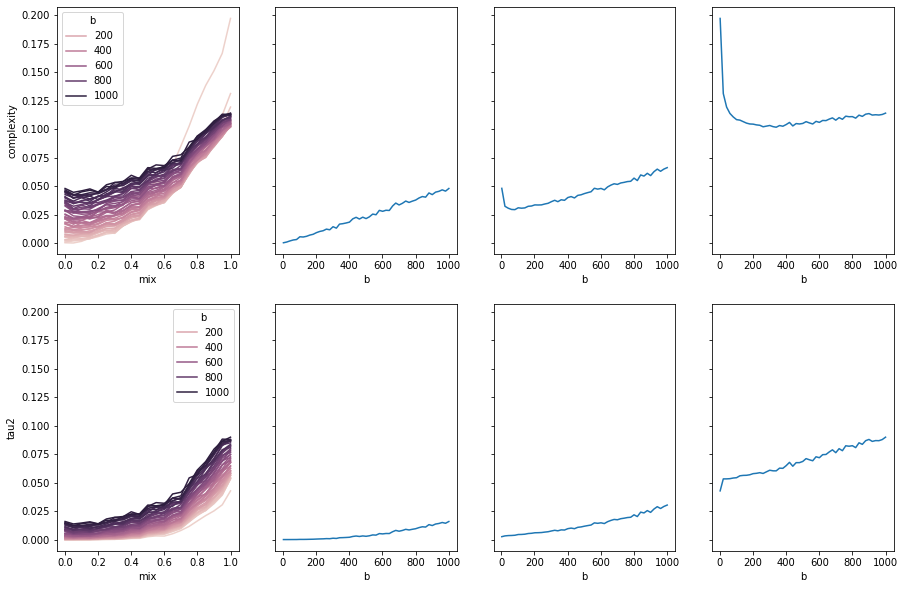

In [4]:
df = bin_scan(2000, minimum=3)

## Different levels of observations

This is consistent across different levels of observations

<ipython-input-50-4bb57ed5ba34>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  observations = np.array([


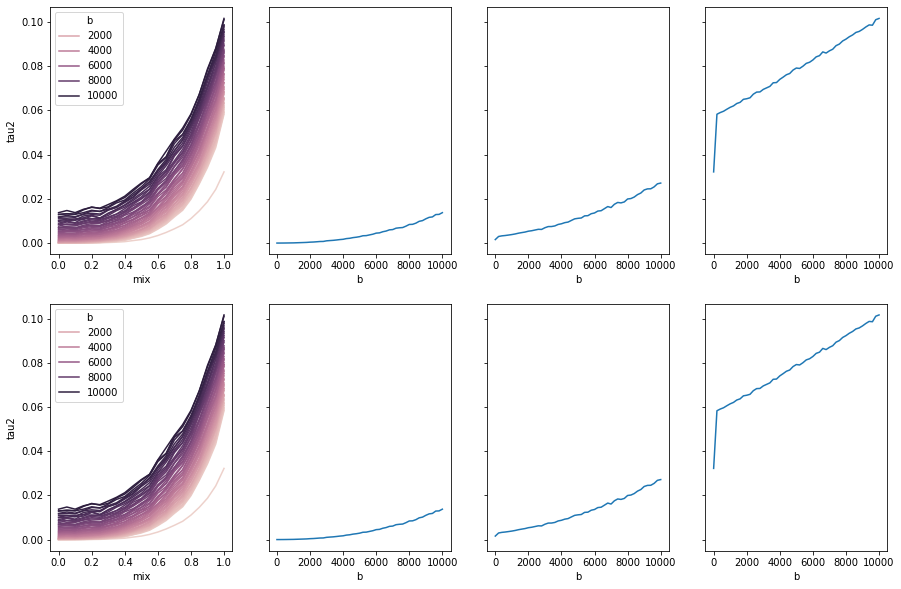

In [52]:
df = bin_scan(20000)

<ipython-input-50-4bb57ed5ba34>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  observations = np.array([


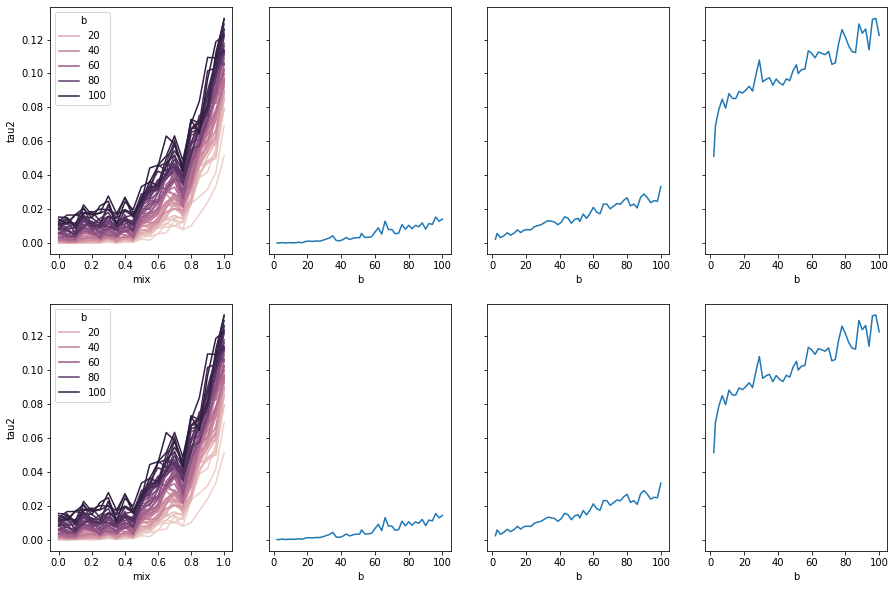

In [53]:
df = bin_scan(200)

## Different powers of complexity

Increasing the level of complexity between ensembles also see's this pattern.

<ipython-input-50-4bb57ed5ba34>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  observations = np.array([


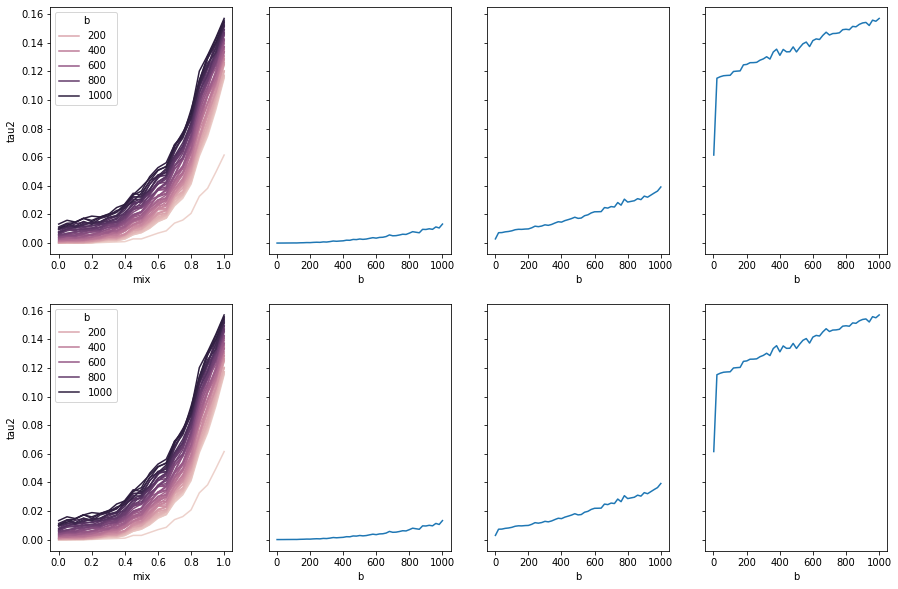

In [54]:
df = bin_scan(2000, power=4)

<ipython-input-50-4bb57ed5ba34>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  observations = np.array([


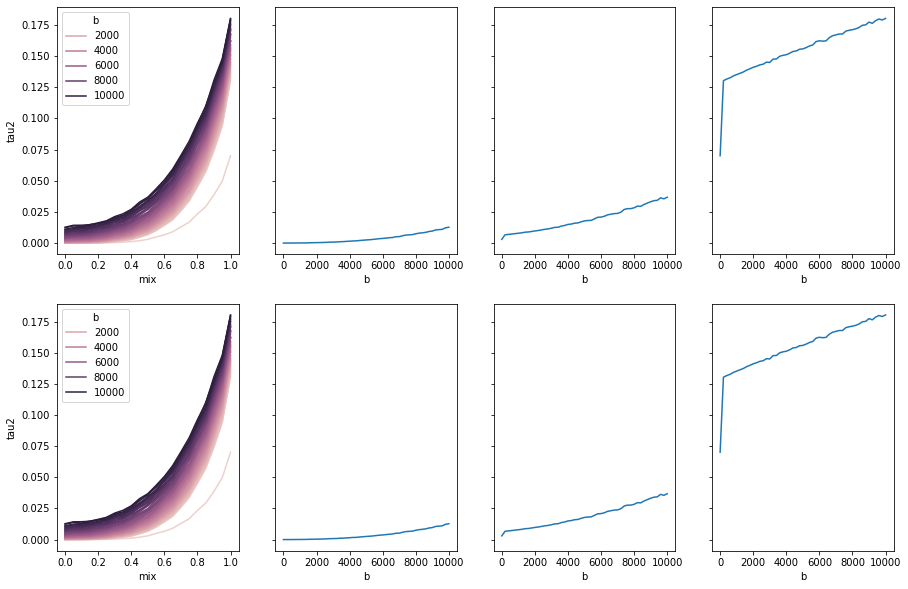

In [55]:
df = bin_scan(20000, power=4)

## First fifth

Gives a much more stable pattern. First showing the full range for reference, then only the first fifth.

<ipython-input-50-4bb57ed5ba34>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  observations = np.array([


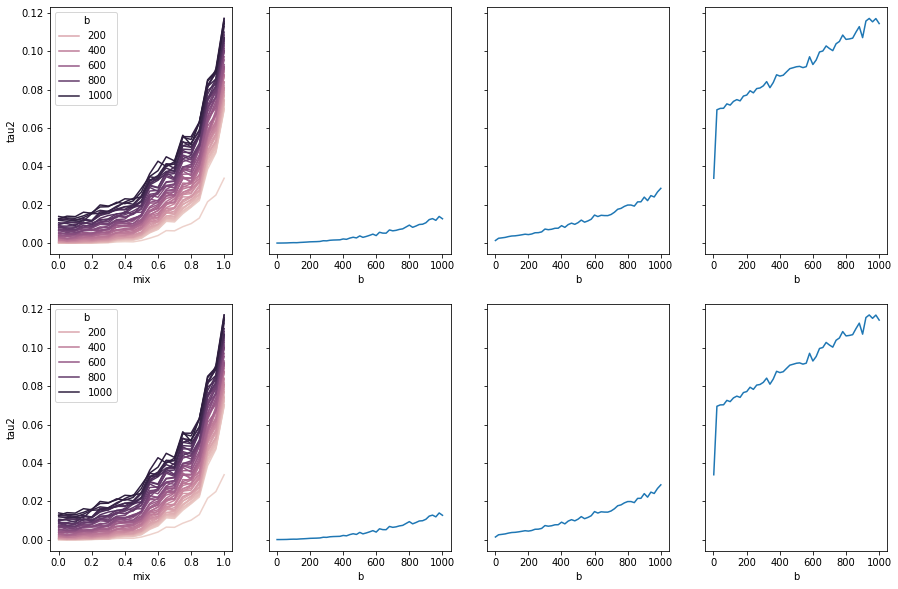

In [56]:
df = bin_scan(2000)

<ipython-input-8-3ef49e2c2e4a>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  observations = np.array([


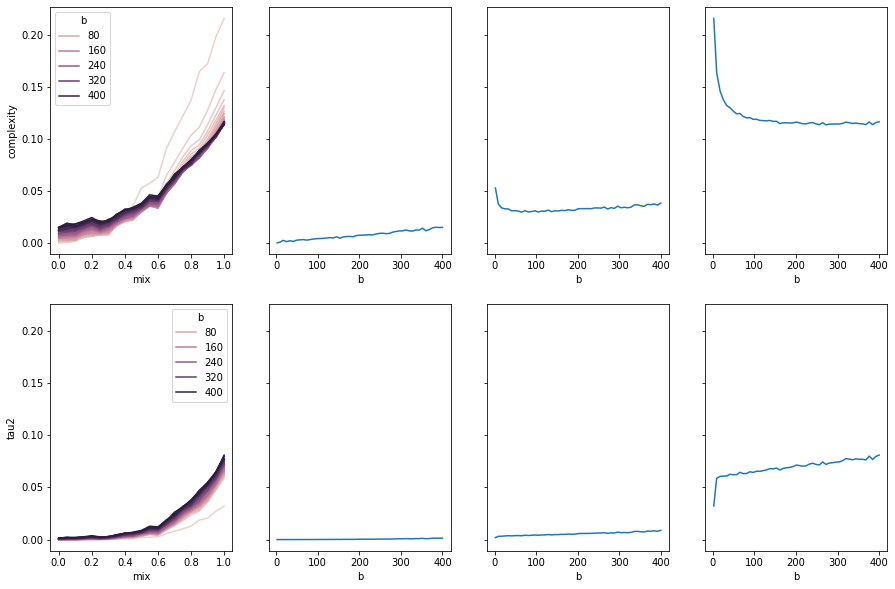

In [15]:
df = bin_scan(2000, maximum=2000/5)

<ipython-input-8-3ef49e2c2e4a>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  observations = np.array([


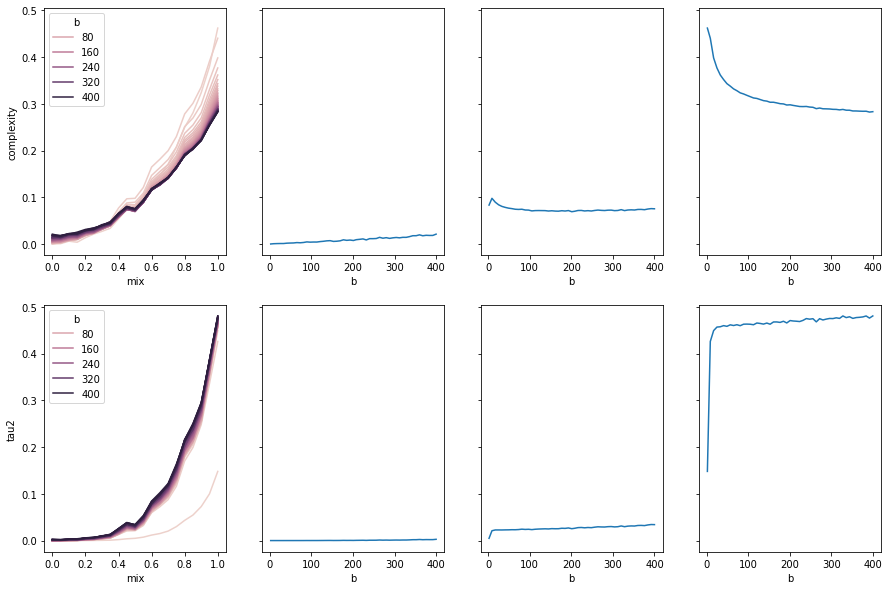

In [16]:
df = bin_scan(2000, maximum=2000/5, power=8)

# Stabilize

Therefore a stabilize function was created, so easily find the lowest value for any continuous distribution

In [62]:
def erg_stabilize(mix, obs=2000, power=2):
    observations = np.array([
                np.random.uniform(size=int(2*obs)),
                np.concatenate([np.random.uniform(size=int(obs*(1-mix))), np.random.power(power,size=int(obs*mix))]),
            ])
    ep.ErgodicEnsemble(observations).stabilize(plot=True)

<ipython-input-62-71de019d3a35>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  observations = np.array([


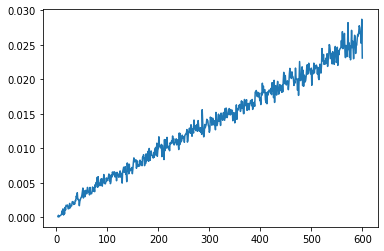

In [63]:
erg_stabilize(0.0)

<ipython-input-62-71de019d3a35>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  observations = np.array([


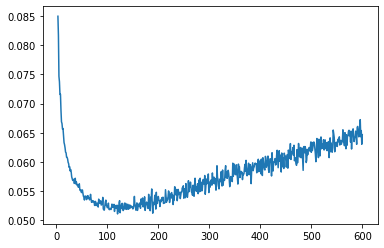

In [64]:
erg_stabilize(1.0)